In [0]:
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf



import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler #, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import sys


import warnings
warnings.filterwarnings("ignore")
#import plotly
#import plotly.graph_objs as go

#import plotly.plotly as py
#import cufflinks as cf


#from sklearn.metrics import r2_score

#import rpy2
#print(rpy2.__version__)#

#import warnings
#from collections import Counter

print(tf.test.gpu_device_name()) 

!cat /proc/meminfo



MemTotal:       13335268 kB
MemFree:         8842192 kB
MemAvailable:   11607280 kB
Buffers:           84384 kB
Cached:          1326324 kB
SwapCached:            0 kB
Active:          1605124 kB
Inactive:        2656736 kB
Active(anon):    1309516 kB
Inactive(anon):      332 kB
Active(file):     295608 kB
Inactive(file):  2656404 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               452 kB
Writeback:             0 kB
AnonPages:       2851272 kB
Mapped:           278552 kB
Shmem:               864 kB
Slab:             138204 kB
SReclaimable:     108620 kB
SUnreclaim:        29584 kB
KernelStack:        4064 kB
PageTables:        12272 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667632 kB
Committed_AS:    4757104 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages: 

In [0]:

try:
    connection = psycopg2.connect(user="sesyr",
                                  password="SeSyR54",
                                  host="51.254.68.36",
                                  port="5432",
                  
                                  database="donnees_trafic")
    cursor = connection.cursor()

    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")
    
    postgreSQL_select_Query = """
    WITH metadata AS (
          SELECT ist.macrosection,
         ist.code_centrale,
         cnl.code_canal,
         sc.sens,
         cc.id_nature_mesure, cc.libelle
        FROM rdv.info_section_troncon ist
        JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
    JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
    JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
    JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%QT_360 %'::text
    
    ), metadatavt AS (
          SELECT distinct ist.macrosection,
         ist.code_centrale,
         cnl.code_canal,
         sc.sens,
         cc.id_nature_mesure, cc.libelle
        FROM rdv.info_section_troncon ist
        JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
    JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
    JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
    JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%VT_360 %'::text
    )
    
    SELECT 
       
       m.macrosection,
       m.sens,
       m.code_centrale,
       m.code_canal, 
       
        
       ts,
       dq.valeur AS qt,
       dv.valeur AS vt
       
       
      FROM metadata  m
      JOIN metadatavt v
      ON m.macrosection = v.macrosection AND m.sens = v.sens AND m.code_centrale = v.code_centrale AND  m.code_canal=  v.code_canal
      
      CROSS JOIN generate_series('2017-05-01' , '2017-07-01','00:06:00'::interval) AS  ts(ts)
      
      LEFT JOIN myrabel.mesure_2 dq    
      ON dq.id_nature_mesure = m.id_nature_mesure
      AND dq.date_mesure = ts 
      
        LEFT JOIN myrabel.mesure_2 dv    
      ON dv.id_nature_mesure = v.id_nature_mesure
      AND dv.date_mesure = ts
      
      
        --WHERE(  dv.date_mesure IS NULL OR dq.date_mesure IS NULL OR dv.date_mesure = dq.date_mesure )
      
     -- WHERE dq.date_mesure IS NOT  NULL AND dv.date_mesure IS NULL  --OR dq.date_mesure IS NULL
      
      """
    

    cursor.execute(postgreSQL_select_Query)
    print("Selecting rows from mobile table using cursor.fetchall")
    records = cursor.fetchall() 
   
   # print("Print each row and it's columns values")
   #for row in records:
       #   print("Macrosection = ", row[0])
        #  print("sens = ", row[1])
         # print("code centrale   = ", row[2])
          #print(" code canal = ", row[3])
        #  print("date_mesure = ", row[4])
         # print("qt_360 = ", row[5]) 
          #print("Vt_360 = ", row[6],"\n" )
            
            
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
        
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")            

You are connected to -  ('PostgreSQL 10.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-28), 64-bit',) 

Selecting rows from mobile table using cursor.fetchall
PostgreSQL connection is closed


In [0]:
df = pd.DataFrame(records, columns=['Macrosection','sens','code_centrale','code_canal','date','qt_360','vt_360'])

#strip code canal which is a char of 3 character with whitespace
#df['code_canal'] = df['code_canal'].str.strip()
df.date = pd.to_datetime(df.date, format='%d/%b/%Y:%H:%M:%S', utc=True)
df= df.set_index('date')
    
df = df.drop(["sens", "Macrosection"], axis=1)
df = df.replace(0,np.NaN) # np.NaN ca va marcher , np.nan doesnt work anymore !!

df.head()

,code_centrale,code_canal,qt_360,vt_360
date,,,,
2017-04-30 22:00:00+00:00,MZE54.3,0,33.0,97.0
2017-04-30 22:06:00+00:00,MZE54.3,0,26.0,95.0
2017-04-30 22:12:00+00:00,MZE54.3,0,36.0,98.0
2017-04-30 22:18:00+00:00,MZE54.3,0,29.0,96.0
2017-04-30 22:24:00+00:00,MZE54.3,0,37.0,94.0


In [0]:
DataFrameDict=df.groupby(['code_canal','code_centrale'])
    
#print to s
for key, item in DataFrameDict:
    print(DataFrameDict.get_group(key), "\n\n")
    #print (key)
    #DataFrameDict.get_group(key).to_csv(r'C:\Users\hp\Desktop\Stage IOT TS\devellopement\grouping_by_codes'+ str(key) +'.csv')   


                          code_centrale code_canal  qt_360  vt_360
date                                                              
2017-04-30 22:00:00+00:00       MZE54.3        0      33.0    97.0
2017-04-30 22:06:00+00:00       MZE54.3        0      26.0    95.0
2017-04-30 22:12:00+00:00       MZE54.3        0      36.0    98.0
2017-04-30 22:18:00+00:00       MZE54.3        0      29.0    96.0
2017-04-30 22:24:00+00:00       MZE54.3        0      37.0    94.0
2017-04-30 22:30:00+00:00       MZE54.3        0      26.0    99.0
2017-04-30 22:36:00+00:00       MZE54.3        0      35.0    97.0
2017-04-30 22:42:00+00:00       MZE54.3        0      17.0    90.0
2017-04-30 22:48:00+00:00       MZE54.3        0      23.0    94.0
2017-04-30 22:54:00+00:00       MZE54.3        0      18.0   103.0
2017-04-30 23:00:00+00:00       MZE54.3        0      15.0    92.0
2017-04-30 23:06:00+00:00       MZE54.3        0      14.0    95.0
2017-04-30 23:12:00+00:00       MZE54.3        0      16.0    

In [0]:
for k, v in DataFrameDict:
      ax=DataFrameDict.get_group(k).plot(figsize =(22,10))
      ax.set_ylabel(k)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
group = [0]*27
for i, (k, v) in enumerate(DataFrameDict):
    group[i] = DataFrameDict.get_group(k)
   

In [0]:
# # Create table for missing data analysis
# def find_missing_data(data):
#     Total = data.isnull().sum().sort_values(ascending = False)
#     Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
#     return pd.concat([Total,Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

In [0]:
for i in range(len(group)):
      group[i] = group[i].drop(["code_centrale", "code_canal"], axis=1)


In [0]:
del group[12]

group

[                           qt_360  vt_360
 date                                     
 2017-04-30 22:00:00+00:00    33.0    97.0
 2017-04-30 22:06:00+00:00    26.0    95.0
 2017-04-30 22:12:00+00:00    36.0    98.0
 2017-04-30 22:18:00+00:00    29.0    96.0
 2017-04-30 22:24:00+00:00    37.0    94.0
 2017-04-30 22:30:00+00:00    26.0    99.0
 2017-04-30 22:36:00+00:00    35.0    97.0
 2017-04-30 22:42:00+00:00    17.0    90.0
 2017-04-30 22:48:00+00:00    23.0    94.0
 2017-04-30 22:54:00+00:00    18.0   103.0
 2017-04-30 23:00:00+00:00    15.0    92.0
 2017-04-30 23:06:00+00:00    14.0    95.0
 2017-04-30 23:12:00+00:00    16.0    99.0
 2017-04-30 23:18:00+00:00     9.0   101.0
 2017-04-30 23:24:00+00:00    10.0    92.0
 2017-04-30 23:30:00+00:00    13.0    96.0
 2017-04-30 23:36:00+00:00    14.0    93.0
 2017-04-30 23:42:00+00:00     9.0    94.0
 2017-04-30 23:48:00+00:00    15.0    91.0
 2017-04-30 23:54:00+00:00    14.0    93.0
 2017-05-01 00:00:00+00:00    12.0   100.0
 2017-05-01

In [0]:
merged = group[0]
for i in range(len(group)-1):
      merged = pd.merge(merged,group[i+1], on='date',how ='left')

In [0]:
# merged.columns = ['qt_dv00', 'vt_dv00', 'qt_dv01', 'vt_dv01', 'qt_dv02', 'vt_dv02',
#        'qt_dv03', 'vt_dv03', 'qt_dv04', 'vt_dv04', 'qt_dv05', 'vt_dv05',
#        'qt_dv06', 'vt_dv06', 'qt_dv07', 'vt_dv07', 'qt_dv08', 'vt_dv08',
#        'qt_dv09', 'vt_dv09', 'qt_dv10', 'vt_dv10', 'qt_dv11', 'vt_dv11',
#        'qt_dv12', 'vt_dv12', 'qt_dv13', 'vt_dv13', 'qt_dv14', 'vt_dv14',
#        'qt_dv15', 'vt_dv15', 'qt_dv16', 'vt_dv16', 'qt_dv17', 'vt_dv17',
#        'qt_dv18', 'vt_dv18', 'qt_dv19', 'vt_dv19', 'qt_dv20', 'vt_dv20',
#        'qt_dv21', 'vt_dv21', 'qt_dv22', 'vt_dv22', 'qt_dv23', 'vt_dv23',
#        'qt_dv24', 'vt_dv24', 'qt_dv25', 'vt_dv25'
#             ]

In [0]:
merged.columns = pd.MultiIndex.from_product( [
                                            ['Device_0', 'Device_1','Device_2', 'Device_3', 'Device_4', 'Device_5', 'Device_6', 'Device_7', 'Device_8', 'Device_9'
                                           ,'Device_10', 'Device_11', 'Device_12', 'Device_13', 'Device_14', 'Device_15', 'Device_16', 'Device_17', 'Device_18'
                                           ,'Device_19', 'Device_20', 'Device_21', 'Device_22', 'Device_23', 'Device_24', 'Device_25']
                                           ,  ['qt', 'vt']])

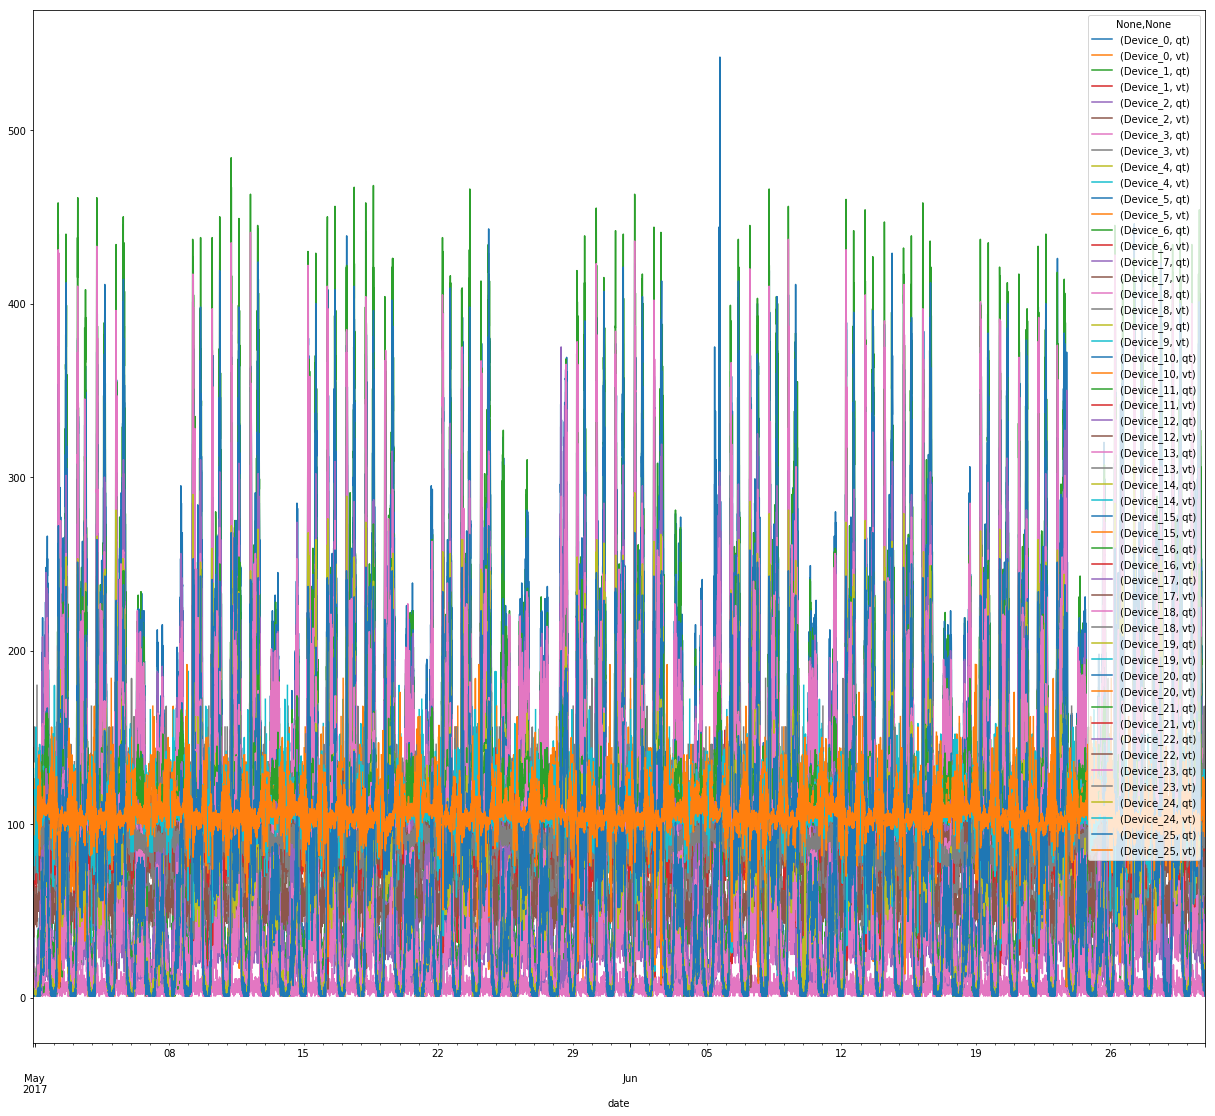

In [0]:
merged.plot(figsize=(21,19))

In [0]:
#Downsample to desired rate
Dataset = merged.resample('60T', how='mean')

#Dataset = Dataset.dropna(axis=[0, 1],how='all')

Dataset['Various', 'Day'] = Dataset.index.dayofyear
Dataset['Various', 'Hour'] = Dataset.index.hour

Dataset.values.shape

(1465, 54)

In [0]:
df_targets = Dataset['Device_18']
df_targets.head(25)

In [0]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

df_targets.shift(-shift_steps)

#df[target_device].head(shift_steps + 5)



NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has NaN for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

## These are the input-signals:


In [0]:
x_data = Dataset.values[shift_steps:]

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1441, 54)


In [0]:
df_targets[:-shift_steps]

,qt,vt
date,,
2017-04-30 22:00:00+00:00,1.333333,110.000000
2017-04-30 23:00:00+00:00,1.000000,119.000000
2017-05-01 00:00:00+00:00,1.000000,102.000000
2017-05-01 01:00:00+00:00,NaN,NaN
2017-05-01 02:00:00+00:00,1.000000,76.000000
2017-05-01 03:00:00+00:00,2.000000,90.000000
2017-05-01 04:00:00+00:00,1.000000,102.666667
2017-05-01 05:00:00+00:00,1.200000,112.200000
2017-05-01 06:00:00+00:00,2.125000,113.633375


In [0]:
y_data = df_targets.values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1441, 2)
